<a href="https://colab.research.google.com/github/Pembo2008/engagement-recognition/blob/main/course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***ПРОЕКТ ЭМОЦИОНАЛЬНАЯ ВОВЛЕЧЕННОСТЬ УЧАСТНИКОВ ОНЛАЙН МЕРОПРИЯТИЯ***

Импорт библиотек

In [1]:
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from collections import defaultdict
import os
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import torch
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout, Flatten, LSTM, Activation, MaxPooling2D
from tensorflow.keras.regularizers import l2 as L2_reg
from tensorflow.keras.layers import Conv2D, BatchNormalization,MaxPool2D, GlobalMaxPool2D, Input, Masking, Conv3D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.compat.v1.keras.backend import set_session
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

In [2]:
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
DATA_DIR = '/content/drive/MyDrive/project/Датасэт'

## **Preparing** **data**

In [ ]:
def process_dir(dirname):
    print(dirname)
    d=os.path.join(DATA_DIR,dirname)
    for filename in tqdm(os.listdir(d)):
        if filename.lower().endswith('ini'):
            continue
        if os.path.isdir(os.path.join(d,filename)):
            videofile=None
            for fn in os.listdir(os.path.join(d,filename)):
                if fn.lower().endswith('ini'):
                    continue
                videofile=fn
            if videofile is None:
                print(filename)
                continue
            filename=os.path.join(filename,videofile)
        fn, ext = os.path.splitext(os.path.basename(filename))
        outdir=os.path.join(d,fn)
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        command = "ffmpeg -i "+os.path.join(d,filename) + " -r 0.5 '"+outdir+"/%05d.png'"
        print(command)
        os.system(command=command)

process_dir('Test')

In [ ]:
process_dir('Train')

In [ ]:
process_dir('Validation')

In [ ]:
def extract_openface_features(dirname,outdir):
    print(dirname)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    os.chdir(dirname)
    command='/home/avsavchenko/src/distr/OpenFace/build/bin/FeatureExtraction -pose -aus -gaze -out_dir '+outdir
    for filename in os.listdir('.'):
        if filename.lower().endswith('ini'):
            continue
        
        if os.path.isdir(filename):
            command+=' -fdir '+filename
        
    print(command)
    os.system(command=command)

cur_dir=os.getcwd()
extract_openface_features(os.path.join(DATA_DIR,'frames/validation/'),os.path.join(DATA_DIR,'frames/faces/openface/validation/'))
extract_openface_features(os.path.join(DATA_DIR,'frames/Train/'),os.path.join(DATA_DIR,'frames/faces/openface/Train/'))
os.chdir(cur_dir)
print(os.getcwd())

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
import argparse
import tensorflow as tf
import numpy as np
import cv2
import time

import subprocess, re 


def is_specialfile(path,exts):
    _, file_extension = os.path.splitext(path)
    return file_extension.lower() in exts

img_extensions=['.jpg','.jpeg','.png']
def is_image(path):
    return is_specialfile(path,img_extensions)

video_extensions=['.mov','.avi']
def is_video(path):
    return is_specialfile(path,video_extensions)
    
class FacialImageProcessing:
    # minsize: minimum of faces' size
    def __init__(self, print_stat=False, minsize = 16):
        self.print_stat=print_stat
        self.minsize=minsize
        
        models_path = '/content/drive/MyDrive/project/Датасэт/Models'
        # models_path=os.path.join(models_path,'..','models','pretrained_faces')
        model_files={os.path.join(models_path,'mtcnn.pb'):''}

        with tf.Graph().as_default() as full_graph:
            for model_file in model_files:
                tf.import_graph_def(FacialImageProcessing.load_graph_def(model_file), name=model_files[model_file])
        self.sess=tf.compat.v1.Session(graph=full_graph)#,config=tf.ConfigProto(device_count={'CPU':1,'GPU':0}))
        self.pnet, self.rnet, self.onet = FacialImageProcessing.load_mtcnn(self.sess,full_graph)     

    def close(self):
        self.sess.close()
    
    @staticmethod
    def load_graph_def(frozen_graph_filename):
        graph_def=None
        with tf.io.gfile.GFile(frozen_graph_filename, 'rb') as f:
            graph_def = tf.compat.v1.GraphDef()
            graph_def.ParseFromString(f.read())
        return graph_def
    
    @staticmethod
    def load_graph(frozen_graph_filename, prefix=''):
        graph_def = FacialImageProcessing.load_graph_def(frozen_graph_filename)
        with tf.Graph().as_default() as graph:
            tf.import_graph_def(graph_def, name=prefix)
        return graph

    @staticmethod
    def load_mtcnn(sess,graph):
        pnet_out_1=graph.get_tensor_by_name('pnet/conv4-2/BiasAdd:0')
        pnet_out_2=graph.get_tensor_by_name('pnet/prob1:0')
        pnet_in=graph.get_tensor_by_name('pnet/input:0')
        
        rnet_out_1=graph.get_tensor_by_name('rnet/conv5-2/conv5-2:0')
        rnet_out_2=graph.get_tensor_by_name('rnet/prob1:0')
        rnet_in=graph.get_tensor_by_name('rnet/input:0')
        
        onet_out_1=graph.get_tensor_by_name('onet/conv6-2/conv6-2:0')
        onet_out_2=graph.get_tensor_by_name('onet/conv6-3/conv6-3:0')
        onet_out_3=graph.get_tensor_by_name('onet/prob1:0')
        onet_in=graph.get_tensor_by_name('onet/input:0')
        
        pnet_fun = lambda img : sess.run((pnet_out_1, pnet_out_2), feed_dict={pnet_in:img})
        rnet_fun = lambda img : sess.run((rnet_out_1, rnet_out_2), feed_dict={rnet_in:img})
        onet_fun = lambda img : sess.run((onet_out_1, onet_out_2, onet_out_3), feed_dict={onet_in:img})
        return pnet_fun, rnet_fun, onet_fun
        
    @staticmethod
    def bbreg(boundingbox,reg):
        # calibrate bounding boxes
        if reg.shape[1]==1:
            reg = np.reshape(reg, (reg.shape[2], reg.shape[3]))

        w = boundingbox[:,2]-boundingbox[:,0]+1
        h = boundingbox[:,3]-boundingbox[:,1]+1
        b1 = boundingbox[:,0]+reg[:,0]*w
        b2 = boundingbox[:,1]+reg[:,1]*h
        b3 = boundingbox[:,2]+reg[:,2]*w
        b4 = boundingbox[:,3]+reg[:,3]*h
        boundingbox[:,0:4] = np.transpose(np.vstack([b1, b2, b3, b4 ]))
        return boundingbox
     
    @staticmethod
    def generateBoundingBox(imap, reg, scale, t):
        # use heatmap to generate bounding boxes
        stride=2
        cellsize=12

        imap = np.transpose(imap)
        dx1 = np.transpose(reg[:,:,0])
        dy1 = np.transpose(reg[:,:,1])
        dx2 = np.transpose(reg[:,:,2])
        dy2 = np.transpose(reg[:,:,3])
        y, x = np.where(imap >= t)
        if y.shape[0]==1:
            dx1 = np.flipud(dx1)
            dy1 = np.flipud(dy1)
            dx2 = np.flipud(dx2)
            dy2 = np.flipud(dy2)
        score = imap[(y,x)]
        reg = np.transpose(np.vstack([ dx1[(y,x)], dy1[(y,x)], dx2[(y,x)], dy2[(y,x)] ]))
        if reg.size==0:
            reg = np.empty((0,3))
        bb = np.transpose(np.vstack([y,x]))
        q1 = np.fix((stride*bb+1)/scale)
        q2 = np.fix((stride*bb+cellsize-1+1)/scale)
        boundingbox = np.hstack([q1, q2, np.expand_dims(score,1), reg])
        return boundingbox, reg
     
    # function pick = nms(boxes,threshold,type)
    @staticmethod
    def nms(boxes, threshold, method):
        if boxes.size==0:
            return np.empty((0,3))
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]
        s = boxes[:,4]
        area = (x2-x1+1) * (y2-y1+1)
        I = np.argsort(s)
        pick = np.zeros_like(s, dtype=np.int16)
        counter = 0
        while I.size>0:
            i = I[-1]
            pick[counter] = i
            counter += 1
            idx = I[0:-1]
            xx1 = np.maximum(x1[i], x1[idx])
            yy1 = np.maximum(y1[i], y1[idx])
            xx2 = np.minimum(x2[i], x2[idx])
            yy2 = np.minimum(y2[i], y2[idx])
            w = np.maximum(0.0, xx2-xx1+1)
            h = np.maximum(0.0, yy2-yy1+1)
            inter = w * h
            if method == 'Min':
                o = inter / np.minimum(area[i], area[idx])
            else:
                o = inter / (area[i] + area[idx] - inter)
            I = I[np.where(o<=threshold)]
        pick = pick[0:counter]
        return pick

    # function [dy edy dx edx y ey x ex tmpw tmph] = pad(total_boxes,w,h)
    @staticmethod
    def pad(total_boxes, w, h):
        # compute the padding coordinates (pad the bounding boxes to square)
        tmpw = (total_boxes[:,2]-total_boxes[:,0]+1).astype(np.int32)
        tmph = (total_boxes[:,3]-total_boxes[:,1]+1).astype(np.int32)
        numbox = total_boxes.shape[0]

        dx = np.ones((numbox), dtype=np.int32)
        dy = np.ones((numbox), dtype=np.int32)
        edx = tmpw.copy().astype(np.int32)
        edy = tmph.copy().astype(np.int32)

        x = total_boxes[:,0].copy().astype(np.int32)
        y = total_boxes[:,1].copy().astype(np.int32)
        ex = total_boxes[:,2].copy().astype(np.int32)
        ey = total_boxes[:,3].copy().astype(np.int32)

        tmp = np.where(ex>w)
        edx.flat[tmp] = np.expand_dims(-ex[tmp]+w+tmpw[tmp],1)
        ex[tmp] = w
        
        tmp = np.where(ey>h)
        edy.flat[tmp] = np.expand_dims(-ey[tmp]+h+tmph[tmp],1)
        ey[tmp] = h

        tmp = np.where(x<1)
        dx.flat[tmp] = np.expand_dims(2-x[tmp],1)
        x[tmp] = 1

        tmp = np.where(y<1)
        dy.flat[tmp] = np.expand_dims(2-y[tmp],1)
        y[tmp] = 1
        
        return dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph

    # function [bboxA] = rerec(bboxA)
    @staticmethod
    def rerec(bboxA):
        # convert bboxA to square
        h = bboxA[:,3]-bboxA[:,1]
        w = bboxA[:,2]-bboxA[:,0]
        l = np.maximum(w, h)
        bboxA[:,0] = bboxA[:,0]+w*0.5-l*0.5
        bboxA[:,1] = bboxA[:,1]+h*0.5-l*0.5
        bboxA[:,2:4] = bboxA[:,0:2] + np.transpose(np.tile(l,(2,1)))
        return bboxA

    def detect_faces(self,img):
        # im: input image
        # threshold: threshold=[th1 th2 th3], th1-3 are three steps's threshold
        threshold = [ 0.6, 0.7, 0.9 ]  # three steps's threshold
        # fastresize: resize img from last scale (using in high-resolution images) if fastresize==true
        factor = 0.709 # scale factor
        factor_count=0
        total_boxes=np.empty((0,9))
        points=np.array([])
        h=img.shape[0]
        w=img.shape[1]
        minl=np.amin([h, w])
        m=12.0/self.minsize
        minl=minl*m
        # creat scale pyramid
        scales=[]
        while minl>=12:
            scales += [m*np.power(factor, factor_count)]
            minl = minl*factor
            factor_count += 1

        # first stage
        #t=time.time()
        for j in range(len(scales)):
            scale=scales[j]
            hs=int(np.ceil(h*scale))
            ws=int(np.ceil(w*scale))
            im_data = cv2.resize(img, (ws,hs), interpolation=cv2.INTER_AREA)
            im_data = (im_data-127.5)*0.0078125
            img_x = np.expand_dims(im_data, 0)
            img_y = np.transpose(img_x, (0,2,1,3))
            out = self.pnet(img_y)
            out0 = np.transpose(out[0], (0,2,1,3))
            out1 = np.transpose(out[1], (0,2,1,3))
            
            boxes, _ = FacialImageProcessing.generateBoundingBox(out1[0,:,:,1].copy(), out0[0,:,:,:].copy(), scale, threshold[0])
            
            # inter-scale nms
            pick = FacialImageProcessing.nms(boxes.copy(), 0.5, 'Union')
            if boxes.size>0 and pick.size>0:
                boxes = boxes[pick,:]
                total_boxes = np.append(total_boxes, boxes, axis=0)
        numbox = total_boxes.shape[0]
        #elapsed = time.time() - t
        #print('1 phase nb=%d elapsed=%f'%(numbox,elapsed))
        if numbox>0:
            pick = FacialImageProcessing.nms(total_boxes.copy(), 0.7, 'Union')
            total_boxes = total_boxes[pick,:]
            regw = total_boxes[:,2]-total_boxes[:,0]
            regh = total_boxes[:,3]-total_boxes[:,1]
            qq1 = total_boxes[:,0]+total_boxes[:,5]*regw
            qq2 = total_boxes[:,1]+total_boxes[:,6]*regh
            qq3 = total_boxes[:,2]+total_boxes[:,7]*regw
            qq4 = total_boxes[:,3]+total_boxes[:,8]*regh
            total_boxes = np.transpose(np.vstack([qq1, qq2, qq3, qq4, total_boxes[:,4]]))
            total_boxes = FacialImageProcessing.rerec(total_boxes.copy())
            total_boxes[:,0:4] = np.fix(total_boxes[:,0:4]).astype(np.int32)
            dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = FacialImageProcessing.pad(total_boxes.copy(), w, h)

        numbox = total_boxes.shape[0]
        #elapsed = time.time() - t
        #print('2 phase nb=%d elapsed=%f'%(numbox,elapsed))
        if numbox>0:
            # second stage
            tempimg = np.zeros((24,24,3,numbox))
            for k in range(0,numbox):
                tmp = np.zeros((int(tmph[k]),int(tmpw[k]),3))
                tmp[dy[k]-1:edy[k],dx[k]-1:edx[k],:] = img[y[k]-1:ey[k],x[k]-1:ex[k],:]
                if tmp.shape[0]>0 and tmp.shape[1]>0 or tmp.shape[0]==0 and tmp.shape[1]==0:
                    tempimg[:,:,:,k] = cv2.resize(tmp, (24,24), interpolation=cv2.INTER_AREA)
                else:
                    return np.empty()
            tempimg = (tempimg-127.5)*0.0078125
            tempimg1 = np.transpose(tempimg, (3,1,0,2))
            out = self.rnet(tempimg1)
            out0 = np.transpose(out[0])
            out1 = np.transpose(out[1])
            score = out1[1,:]
            ipass = np.where(score>threshold[1])
            total_boxes = np.hstack([total_boxes[ipass[0],0:4].copy(), np.expand_dims(score[ipass].copy(),1)])
            mv = out0[:,ipass[0]]
            if total_boxes.shape[0]>0:
                pick = FacialImageProcessing.nms(total_boxes, 0.7, 'Union')
                total_boxes = total_boxes[pick,:]
                total_boxes = FacialImageProcessing.bbreg(total_boxes.copy(), np.transpose(mv[:,pick]))
                total_boxes = FacialImageProcessing.rerec(total_boxes.copy())

        numbox = total_boxes.shape[0]
        #elapsed = time.time() - t
        #print('3 phase nb=%d elapsed=%f'%(numbox,elapsed))
        if numbox>0:
            # third stage
            total_boxes = np.fix(total_boxes).astype(np.int32)
            dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = FacialImageProcessing.pad(total_boxes.copy(), w, h)
            tempimg = np.zeros((48,48,3,numbox))
            for k in range(0,numbox):
                tmp = np.zeros((int(tmph[k]),int(tmpw[k]),3))
                tmp[dy[k]-1:edy[k],dx[k]-1:edx[k],:] = img[y[k]-1:ey[k],x[k]-1:ex[k],:]
                if tmp.shape[0]>0 and tmp.shape[1]>0 or tmp.shape[0]==0 and tmp.shape[1]==0:
                    tempimg[:,:,:,k] = cv2.resize(tmp, (48,48), interpolation=cv2.INTER_AREA)
                else:
                    return np.empty()
            tempimg = (tempimg-127.5)*0.0078125
            tempimg1 = np.transpose(tempimg, (3,1,0,2))
            out = self.onet(tempimg1)
            out0 = np.transpose(out[0])
            out1 = np.transpose(out[1])
            out2 = np.transpose(out[2])
            score = out2[1,:]
            points = out1
            ipass = np.where(score>threshold[2])
            points = points[:,ipass[0]]
            total_boxes = np.hstack([total_boxes[ipass[0],0:4].copy(), np.expand_dims(score[ipass].copy(),1)])
            mv = out0[:,ipass[0]]

            w = total_boxes[:,2]-total_boxes[:,0]+1
            h = total_boxes[:,3]-total_boxes[:,1]+1
            points[0:5,:] = np.tile(w,(5, 1))*points[0:5,:] + np.tile(total_boxes[:,0],(5, 1))-1
            points[5:10,:] = np.tile(h,(5, 1))*points[5:10,:] + np.tile(total_boxes[:,1],(5, 1))-1
            if total_boxes.shape[0]>0:
                total_boxes = FacialImageProcessing.bbreg(total_boxes.copy(), np.transpose(mv))
                pick = FacialImageProcessing.nms(total_boxes.copy(), 0.7, 'Min')
                total_boxes = total_boxes[pick,:]
                points = points[:,pick]
        #elapsed = time.time() - t
        #print('4 phase elapsed=%f'%(elapsed))            
        return total_boxes, points

In [ ]:
imgProcessing=FacialImageProcessing(False)

In [ ]:
INPUT_SIZE = (224,224)
def save_faces(source_path,save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.mkdir(os.path.join(save_path, folder))

            for image in os.listdir(os.path.join(source_path, folder)):
                filename = os.path.join(source_path, folder, image)
                frame_bgr = cv2.imread(filename)
                frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                bounding_boxes, _ = imgProcessing.detect_faces(frame)

                if len(bounding_boxes)==0:
                    print('No faces found for ',filename)
                    face_img = frame_bgr
                    faceFound='noface'
                else:
                    if len(bounding_boxes)>1:
                        print('Too many faces (',len(bounding_boxes),') found for ',filename)
                        bounding_boxes=bounding_boxes[:1]

                    b=[int(bi) for bi in bounding_boxes[0]]
                    x1,y1,x2,y2=b[0:4]
                    face_img=frame_bgr[y1:y2,x1:x2,:]

                    if np.prod(face_img.shape)==0:
                        print('Empty face ',b,' found for ',filename)
                        continue
                    
                    faceFound=''

                #face_img=cv2.resize(face_img,INPUT_SIZE)
                root,ext=os.path.splitext(image)
                cv2.imwrite(os.path.join(save_path, folder, root+faceFound+ext), face_img) 
        else:
            print(folder)
        
save_faces(os.path.join(DATA_DIR,'Validation/frames'),os.path.join(DATA_DIR,'cropped/Validation'))

  0%|          | 0/20 [00:00<?, ?it/s]

3_4


 15%|█▌        | 3/20 [02:03<11:12, 39.59s/it]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/3_1_1/00024.png
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/3_1_1/00025.png


 20%|██        | 4/20 [02:42<10:30, 39.42s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/0_1_4/00102.png


 75%|███████▌  | 15/20 [12:16<04:57, 59.41s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00029.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00030.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00031.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00032.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00033.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00034.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00035.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00036.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00037.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00038.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/

 80%|████████  | 16/20 [12:42<03:17, 49.44s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00016.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00017.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00018.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00019.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00020.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00021.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00022.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00023.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00046.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/

100%|██████████| 20/20 [18:13<00:00, 54.69s/it]


In [ ]:
save_faces(os.path.join(DATA_DIR,'Train/frames'),os.path.join(DATA_DIR,'cropped/Train'))

  0%|          | 0/20 [00:00<?, ?it/s]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/1_3/00009.png


  5%|▌         | 1/20 [00:35<11:08, 35.19s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_5_1/00040.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_5_1/00041.png


 20%|██        | 4/20 [02:35<09:56, 37.27s/it]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_3/00045.png
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_3/00050.png


 35%|███▌      | 7/20 [05:58<11:14, 51.91s/it]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_4/00013.png
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_4/00261.png


 40%|████      | 8/20 [06:52<10:31, 52.61s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/1_4_2/00260.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/1_4_2/00261.png


 45%|████▌     | 9/20 [07:44<09:35, 52.36s/it]

Empty face  [-17, 37, 328, 503, 0]  found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_5/00008.png


 55%|█████▌    | 11/20 [10:03<09:16, 61.81s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_3/00079.png


 75%|███████▌  | 15/20 [14:18<05:39, 67.92s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_8/00062.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_8/00063.png


 80%|████████  | 16/20 [15:52<05:02, 75.69s/it]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_2/00079.png
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_2/00082.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_2/00120.png
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_2/00141.png


 95%|█████████▌| 19/20 [18:23<00:59, 59.54s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00014.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00015.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00016.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00048.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00049.png


100%|██████████| 20/20 [19:28<00:00, 58.42s/it]


In [ ]:
save_faces(os.path.join(DATA_DIR,'Test/frames'),os.path.join(DATA_DIR,'cropped/Test'))

 56%|█████▌    | 10/18 [07:39<04:21, 32.65s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_6_1/00008.png


 67%|██████▋   | 12/18 [09:53<05:06, 51.02s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00046.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00048.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00049.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00050.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00051.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00052.png


 72%|███████▏  | 13/18 [10:48<04:21, 52.37s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00053.png


 78%|███████▊  | 14/18 [11:13<02:55, 43.92s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00004.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00005.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00007.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00008.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00009.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00010.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00038.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00078.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00080.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00083.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00098.png


 83%|████████▎ | 15/18 [11:44<02:00, 40.07s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00005.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00046.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00048.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00049.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00060.png


 89%|████████▉ | 16/18 [12:46<01:33, 46.75s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/2_7_3/00059.png


100%|██████████| 18/18 [13:43<00:00, 45.78s/it]


In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou
def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped

In [ ]:
def save_aligned_faces(source_path,save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.mkdir(os.path.join(save_path, folder))

            prev_b = None
            counter = 0

            for image in sorted(os.listdir(os.path.join(source_path, folder))):
                filename = os.path.join(source_path, folder, image)
                frame = cv2.imread(filename)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                bounding_boxes, points = imgProcessing.detect_faces(frame)
                points = points.T

                best_ind=None
                if len(bounding_boxes)==0:
                    print('No faces found for ',filename)
                    counter+=1
                    if prev_b is None or counter>3:
                        continue
                    else:
                        b=prev_b
                elif len(bounding_boxes)>1:
                    print('Too many faces (',len(bounding_boxes),') found for ',filename)
                    if prev_b is None:
                        #continue
                        best_ind=0
                        b=[int(bi) for bi in bounding_boxes[best_ind]]
                        counter=0
                    else:
                        best_iou=0
                        for i in range(len(bounding_boxes)):
                            iou=get_iou(bounding_boxes[i],prev_b)
                            if iou>best_iou:
                                best_iou=iou
                                best_ind=i
                        if best_iou>0:
                            b=[int(bi) for bi in bounding_boxes[best_ind]]
                            print('best_iou (',best_iou,') best_bb ',bounding_boxes[best_ind])
                        else:
                            #continue
                            best_ind=0
                            b=[int(bi) for bi in bounding_boxes[best_ind]]
                            counter=0
                else:
                    best_ind=0
                    b=[int(bi) for bi in bounding_boxes[best_ind]]
                    counter=0
                prev_b=b

                if True:
                    p=None
                    if best_ind is not None:
                        p=points[best_ind]
                        if True: #not USE_RETINA_FACE:
                            p = p.reshape((2,5)).T
                    face_img=preprocess(frame,b,None) #p)
                else:
                    x1,y1,x2,y2=b[0:4]
                    face_img=frame[y1:y2,x1:x2,:]
                if np.prod(face_img.shape)==0:
                    print('Empty face ',b,' found for ',filename)
                    continue

                cv2.imwrite(os.path.join(save_path, folder, image), cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR)) 


In [ ]:
save_aligned_faces(os.path.join(DATA_DIR,'Test/frames'),os.path.join(DATA_DIR,'cropped/aligned/Test'))
save_aligned_faces(os.path.join(DATA_DIR,'Train/frames'),os.path.join(DATA_DIR,'cropped/aligned/Train'))
save_aligned_faces(os.path.join(DATA_DIR,'Validation/frames'),os.path.join(DATA_DIR,'cropped/aligned/Validation'))

 56%|█████▌    | 10/18 [03:21<02:38, 19.79s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_6_1/00008.png


 67%|██████▋   | 12/18 [03:39<01:25, 14.27s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00046.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00048.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00049.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00050.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00051.png


 72%|███████▏  | 13/18 [03:46<01:01, 12.24s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00052.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00053.png


 78%|███████▊  | 14/18 [04:03<00:54, 13.63s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00004.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00005.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00007.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00008.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00009.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00010.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00038.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00078.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00080.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00083.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00098.png


 83%|████████▎ | 15/18 [04:27<00:50, 16.71s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00005.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00046.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00048.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00049.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/3_7/00060.png


 89%|████████▉ | 16/18 [04:36<00:29, 14.58s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/2_7_3/00059.png


  0%|          | 0/20 [00:00<?, ?it/s]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/1_3/00009.png


  5%|▌         | 1/20 [00:04<01:19,  4.18s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_5_1/00040.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_5_1/00041.png


 20%|██        | 4/20 [00:22<01:28,  5.52s/it]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_3/00045.png
best_iou ( 0.916372512227472 ) best_bb  [516.49691224 267.97326466 829.64618979 658.17209919   0.99981612]
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_3/00050.png
best_iou ( 0.9473058242826751 ) best_bb  [519.12025835 284.79786108 817.42057169 652.12221571   0.99972814]


 35%|███▌      | 7/20 [01:08<02:50, 13.15s/it]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_4/00013.png
best_iou ( 0.9234273690789145 ) best_bb  [475.37224981 186.67947021 816.3252193  603.70967044   0.9999826 ]
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_4/00261.png
best_iou ( 0.9778373073006733 ) best_bb  [545.5022539  255.66013668 863.21906434 632.36798665   0.99998927]


 40%|████      | 8/20 [01:55<04:47, 23.99s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/1_4_2/00260.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/1_4_2/00261.png


 55%|█████▌    | 11/20 [03:01<03:02, 20.32s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_3/00079.png


 75%|███████▌  | 15/20 [04:14<01:20, 16.16s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_8/00062.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_8/00063.png


 80%|████████  | 16/20 [04:28<01:01, 15.46s/it]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_2/00079.png
best_iou ( 0.9075012311702716 ) best_bb  [481.54323623 210.60274518 795.28766022 601.39398643   0.99975258]
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_2/00082.png
best_iou ( 0.8534814484071754 ) best_bb  [498.85488441 221.17923245 809.19997276 612.9591307    0.9999845 ]
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_2/00120.png
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/2_4_2/00141.png
best_iou ( 0.9751544909560749 ) best_bb  [581.34304529 230.50527787 908.05537689 635.29753804   0.99985504]


 95%|█████████▌| 19/20 [05:46<00:23, 23.68s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00014.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00015.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00016.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00048.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_1/00049.png


 15%|█▌        | 3/20 [00:58<05:29, 19.40s/it]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/3_1_1/00024.png
best_iou ( 0.8934027995232813 ) best_bb  [578.56169632 413.46994331 722.39009653 598.14491691   0.99999917]
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/3_1_1/00025.png
best_iou ( 0.8662883953183266 ) best_bb  [586.53905678 405.71091448 727.80274872 596.7704048    0.99999654]


 20%|██        | 4/20 [01:03<03:39, 13.72s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/0_1_4/00102.png


 75%|███████▌  | 15/20 [03:32<00:55, 11.17s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00029.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00030.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00031.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00032.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00033.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00034.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00035.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00036.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00037.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00038.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/

 80%|████████  | 16/20 [03:54<00:57, 14.46s/it]

No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00016.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00017.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00018.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00019.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00020.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00021.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00022.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00023.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00046.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_6/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/

100%|██████████| 20/20 [04:58<00:00, 14.94s/it]


In [ ]:
save_aligned_faces(os.path.join(DATA_DIR,'Test/frames'),os.path.join(DATA_DIR,'cropped/aligned_2/Test'))
save_aligned_faces(os.path.join(DATA_DIR,'Train/frames'),os.path.join(DATA_DIR,'cropped/aligned_2/Train'))
save_aligned_faces(os.path.join(DATA_DIR,'Validation/frames'),os.path.join(DATA_DIR,'cropped/aligned_2/Validation'))

  0%|          | 0/18 [00:00<?, ?it/s]

No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_6_1/00008.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00046.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00047.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00048.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00049.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00050.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00051.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00052.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7/00053.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00004.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Test/frames/1_7_2/00005.png
No faces found for  /content/drive/MyDrive/project/Датасэт/

  0%|          | 0/20 [00:00<?, ?it/s]

No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/1_3/00009.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_5_1/00040.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Train/frames/0_5_1/00041.png
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_4/00089.png
best_iou ( 0.9596440329438631 ) best_bb  [509.56414306 215.2859764  833.36680609 612.19771779   0.99994576]
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_4/00090.png
best_iou ( 0.9554795359910803 ) best_bb  [517.84188291 215.84387389 837.75404403 612.49367268   0.99998331]
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/3_4_4/00093.png
best_iou ( 0.9452478055665529 ) best_bb  [515.08553337 208.66246748 841.74161211 609.59455252   0.99990535]
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Train/frames/1_4_2/00083.png
best_iou ( 0.9

  0%|          | 0/20 [00:00<?, ?it/s]

Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/3_1_1/00024.png
best_iou ( 0.9849174188163964 ) best_bb  [584.75502819 406.25657268 726.22939119 595.35224442   0.99999487]
Too many faces ( 2 ) found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/3_1_1/00025.png
best_iou ( 0.9508705824101706 ) best_bb  [587.68196878 408.3282536  727.68905687 595.00597186   0.99999821]
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/0_1_4/00102.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00029.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00030.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00031.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00032.png
No faces found for  /content/drive/MyDrive/project/Датасэт/Validation/frames/2_7_5/00033.png
No faces found f

In [ ]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.models import load_model,Model

# Data preprocessing 2

In [4]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/project/Датасэт/cropped/aligned/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train','Test','Validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['Train','Test','Validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train','Test','Validation']}

In [5]:
dataloaders

{'Test': <torch.utils.data.dataloader.DataLoader at 0x7fab4fb78a10>,
 'Train': <torch.utils.data.dataloader.DataLoader at 0x7fab4fb78390>,
 'Validation': <torch.utils.data.dataloader.DataLoader at 0x7fab4fb78950>}

In [6]:
image_datasets['Test'].classes

['0', '1', '2', '3']

In [7]:
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

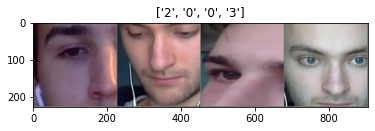

In [8]:
import torchvision


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    CUDA_LAUNCH_BLOCKING = "1"
    since = time.time()

    # best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
import torchvision.models as models

# Resnet

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
import copy
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.9808 Acc: 0.6233
Validation Loss: 1.1165 Acc: 0.5365

Epoch 1/9
----------
Train Loss: 0.8319 Acc: 0.6792
Validation Loss: 1.0281 Acc: 0.6213

Epoch 2/9
----------
Train Loss: 0.8046 Acc: 0.6861
Validation Loss: 0.7854 Acc: 0.6588

Epoch 3/9
----------
Train Loss: 0.7293 Acc: 0.7142
Validation Loss: 1.0451 Acc: 0.6193

Epoch 4/9
----------
Train Loss: 0.6919 Acc: 0.7315
Validation Loss: 0.8552 Acc: 0.6410

Epoch 5/9
----------
Train Loss: 0.6763 Acc: 0.7423
Validation Loss: 0.9584 Acc: 0.6667

Epoch 6/9
----------
Train Loss: 0.6474 Acc: 0.7432
Validation Loss: 0.8579 Acc: 0.6607

Epoch 7/9
----------
Train Loss: 0.5387 Acc: 0.7886
Validation Loss: 0.7354 Acc: 0.7239

Epoch 8/9
----------
Train Loss: 0.5082 Acc: 0.8088
Validation Loss: 0.7377 Acc: 0.7337

Epoch 9/9
----------
Train Loss: 0.4839 Acc: 0.8066
Validation Loss: 0.8264 Acc: 0.7120

Training complete in 9m 1s
Best val Acc: 0.733728


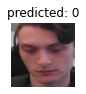

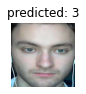

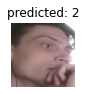

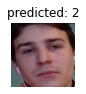

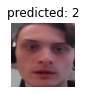

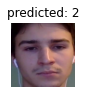

In [ ]:
visualize_model(model_ft)

In [ ]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Train Loss: 1.3557 Acc: 0.4193
Validation Loss: 2.6236 Acc: 0.2468

Epoch 1/24
----------
Train Loss: 1.3072 Acc: 0.4434
Validation Loss: 1.7715 Acc: 0.3362

Epoch 2/24
----------
Train Loss: 1.2968 Acc: 0.4412
Validation Loss: 2.1633 Acc: 0.2959

Epoch 3/24
----------
Train Loss: 1.2841 Acc: 0.4558
Validation Loss: 1.4822 Acc: 0.3470

Epoch 4/24
----------
Train Loss: 1.2343 Acc: 0.4617
Validation Loss: 2.0658 Acc: 0.3376

Epoch 5/24
----------
Train Loss: 1.2339 Acc: 0.4850
Validation Loss: 2.1767 Acc: 0.2260

Epoch 6/24
----------
Train Loss: 1.1707 Acc: 0.5011
Validation Loss: 1.8049 Acc: 0.3020

Epoch 7/24
----------
Train Loss: 1.0823 Acc: 0.5493
Validation Loss: 1.9222 Acc: 0.3658

Epoch 8/24
----------
Train Loss: 1.0457 Acc: 0.5544
Validation Loss: 1.7863 Acc: 0.3605

Epoch 9/24
----------
Train Loss: 1.0514 Acc: 0.5551
Validation Loss: 1.9132 Acc: 0.3611

Epoch 10/24
----------
Train Loss: 1.0271 Acc: 0.5588
Validation Loss: 1.8103 Acc: 0.3645

Epoch 11/

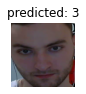

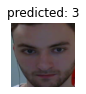

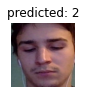

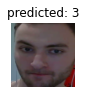

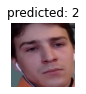

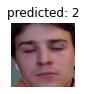

In [ ]:
visualize_model(model_ft)

In [ ]:
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer_ft = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Train Loss: 1.2924 Acc: 0.3647
Validation Loss: 1.4122 Acc: 0.3353

Epoch 1/9
----------
Train Loss: 1.2294 Acc: 0.3732
Validation Loss: 1.4262 Acc: 0.3353

Epoch 2/9
----------
Train Loss: 1.2301 Acc: 0.3669
Validation Loss: 1.4408 Acc: 0.3353

Epoch 3/9
----------
Train Loss: 1.2331 Acc: 0.3773
Validation Loss: 1.4349 Acc: 0.3353

Epoch 4/9
----------
Train Loss: 1.2162 Acc: 0.3726
Validation Loss: 1.4508 Acc: 0.3353

Epoch 5/9
----------
Train Loss: 1.2267 Acc: 0.3675
Validation Loss: 1.4398 Acc: 0.2505

Epoch 6/9
----------
Train Loss: 1.2158 Acc: 0.3801
Validation Loss: 1.4594 Acc: 0.2505

Epoch 7/9
----------
Train Loss: 1.2141 Acc: 0.3744
Validation Loss: 1.4546 Acc: 0.3353

Epoch 8/9
----------
Train Loss: 1.2130 Acc: 0.3833
Validation Loss: 1.4494 Acc: 0.3353

Epoch 9/9
----------
Train Loss: 1.2129 Acc: 0.3833
Validation Loss: 1.4501 Acc: 0.3353

Training complete in 9m 45s
Best val Acc: 0.335306


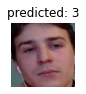

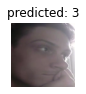

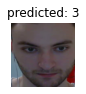

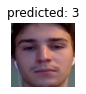

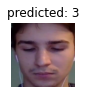

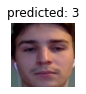

In [ ]:
visualize_model(model_ft)

#AlexNet

In [ ]:
model_an = models.alexnet(pretrained=True)
model_an.classifier[6] = nn.Linear(4096,4)

model_an = model_an.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_an.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
import copy
model_ft = train_model(model_an, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.6714 Acc: 0.7202
Validation Loss: 0.8997 Acc: 0.6134

Epoch 1/9
----------
Train Loss: 0.6569 Acc: 0.7315
Validation Loss: 0.9579 Acc: 0.6706

Epoch 2/9
----------
Train Loss: 0.6002 Acc: 0.7514
Validation Loss: 0.8551 Acc: 0.6785

Epoch 3/9
----------
Train Loss: 0.6022 Acc: 0.7577
Validation Loss: 1.1902 Acc: 0.6312

Epoch 4/9
----------
Train Loss: 0.5135 Acc: 0.7880
Validation Loss: 0.8105 Acc: 0.6903

Epoch 5/9
----------
Train Loss: 0.4833 Acc: 0.8009
Validation Loss: 0.7744 Acc: 0.6903

Epoch 6/9
----------
Train Loss: 0.4721 Acc: 0.8060
Validation Loss: 0.7960 Acc: 0.7061

Epoch 7/9
----------
Train Loss: 0.4441 Acc: 0.8224
Validation Loss: 0.7548 Acc: 0.7002

Epoch 8/9
----------
Train Loss: 0.4655 Acc: 0.8091
Validation Loss: 0.7926 Acc: 0.7041

Epoch 9/9
----------
Train Loss: 0.4560 Acc: 0.8215
Validation Loss: 0.7637 Acc: 0.7239

Training complete in 6m 51s
Best val Acc: 0.723866


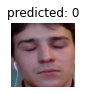

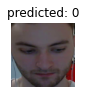

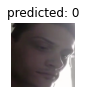

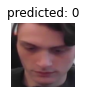

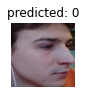

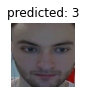

In [ ]:
visualize_model(model_an)

# VGG

In [ ]:
model_vgg = models.vgg11(pretrained=True)
model_vgg.classifier[6] = nn.Linear(4096,4)

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
model_vgg = train_model(model_vgg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.9319 Acc: 0.6022
Validation Loss: 0.9067 Acc: 0.5779

Epoch 1/9
----------
Train Loss: 0.7110 Acc: 0.7063
Validation Loss: 1.1660 Acc: 0.5010

Epoch 2/9
----------
Train Loss: 0.6518 Acc: 0.7334
Validation Loss: 0.8233 Acc: 0.6607

Epoch 3/9
----------
Train Loss: 0.5903 Acc: 0.7615
Validation Loss: 0.7407 Acc: 0.6410

Epoch 4/9
----------


KeyboardInterrupt: ignored

In [ ]:
visualize_model(model_vgg)

# DenseNet

In [ ]:
model_dn = models.densenet121(pretrained=True)
model_dn.classifier = nn.Linear(1024,4)

model_dn = model_dn.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_dn.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
model_dn = train_model(model_dn, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.7838 Acc: 0.6912
Validation Loss: 1.2974 Acc: 0.6391

Epoch 1/9
----------
Train Loss: 0.7038 Acc: 0.7145
Validation Loss: 1.2434 Acc: 0.6765

Epoch 2/9
----------
Train Loss: 0.6961 Acc: 0.7284
Validation Loss: 1.4406 Acc: 0.5897

Epoch 3/9
----------
Train Loss: 0.6576 Acc: 0.7353
Validation Loss: 0.9907 Acc: 0.6233

Epoch 4/9
----------
Train Loss: 0.6037 Acc: 0.7603
Validation Loss: 1.0655 Acc: 0.6529

Epoch 5/9
----------
Train Loss: 0.4642 Acc: 0.8170
Validation Loss: 1.1357 Acc: 0.6647

Epoch 6/9
----------
Train Loss: 0.4526 Acc: 0.8186
Validation Loss: 0.9366 Acc: 0.7298

Epoch 7/9
----------
Train Loss: 0.4569 Acc: 0.8256
Validation Loss: 1.1064 Acc: 0.6805

Epoch 8/9
----------
Train Loss: 0.4237 Acc: 0.8246
Validation Loss: 0.9990 Acc: 0.7101

Epoch 9/9
----------
Train Loss: 0.4314 Acc: 0.8281
Validation Loss: 1.0000 Acc: 0.7022

Training complete in 25m 18s
Best val Acc: 0.729783


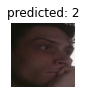

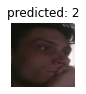

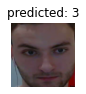

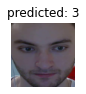

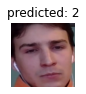

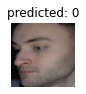

In [ ]:
visualize_model(model_dn)

In [ ]:
PATH = '/content/drive/MyDrive/project/Датасэт/Models/dn_model.pth'
torch.save(model_dn.state_dict(),PATH)

# efficientnet_b6

In [12]:
model_e = models.efficientnet_b6(pretrained = True)

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

In [13]:
model_e.classifier[1] = nn.Linear(2304,4)

model_e = model_e.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_e.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_e = train_model(model_e, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


In [ ]:
visualize_model(model_e)